# Прогнозирование оттока клиентов для фитнес-центра

### Постановка задачи

Сеть фитнес-центров разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных.

**Цель исследования** — провести анализ клиентов и подготовить план действий по удержанию клиентов.

**Задачи исследования:**

* научиться прогнозировать вероятность оттока для каждого клиента;
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

### План исследования

1. Предобработка данных
2. Исследовательский анализ данных
3. Построение модели прогнозирования оттока клиентов
4. Кластеризация клиентов
5. Подготовка выводов и рекомендаций

### Импортирование библиотек

In [1]:
# Импортирование библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

# Игнорировать все предупреждения
warnings.filterwarnings("ignore")

# Зададим стиль для всех графиков
sns.set_style('darkgrid')

### Загрузка данных

In [2]:
# Чтение файла
data = pd.read_csv('/Users/aaleksakhin/Library/CloudStorage/GoogleDrive-aaalexahin@gmail.com/My Drive/Data/Datasets/project_ml_gym/gym_churn.csv')

In [3]:
# Выведение первых пяти строк
data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


### Предобработка и исследовательский анализ данных

Изучим качество данных и при необходимости сделаем предобработку. Для начала выведем основную информацию о датасете методом `.info()`.

In [4]:
# Вывод метода info()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

Датасет состоит из 4 000 строк, ни в одном столбце пропусков нет.

Проверим уникальные значения в столбцах `gender`,
                       `Near_Location`,
                       `Partner`,
                       `Promo_friends`,
                       `Phone`,
                       `Contract_period`
                       `Group_visits` и
                       `Churn`
                       . По условию задания, значения в этих столбцах могут принимать могут быть равны только нулю или единице, кроме `Contract_period` — в этом столбце значения должны быть равны длительности абонемента в месяцах — 1, 6 или 12 

In [5]:
# Создадим список названий столбцов
unique_values_check = ['gender',
                       'Near_Location',
                       'Partner',
                       'Promo_friends',
                       'Phone',
                       'Group_visits',
                       'Churn',
                       'Contract_period']

# Циклом выведем уникальные значения для каждого столбца
for i in unique_values_check:
    print (i, data[i].unique())

gender [1 0]
Near_Location [1 0]
Partner [1 0]
Promo_friends [1 0]
Phone [0 1]
Group_visits [1 0]
Churn [0 1]
Contract_period [ 6 12  1]


Все хорошо, лишних значений нет.

Теперь проверим диапазон значений в столбце `Month_to_end_contract` — значения в этом столбце не должны быть больше максимальной длительности абонемента (12 месяцев) и меньше минимальной длительности (1 месяц).

In [6]:
# Выведем максимальное и минимальное значение столбца Month_to_end_contract
display (data['Month_to_end_contract'].min())
display (data['Month_to_end_contract'].max())

1.0

12.0

Все логично — значения в столбце находятся в верном диапазоне.

Также по логике значения в столбце `Month_to_end_contract` не должны быть больше значения в столбце `Contract_period`, проверим это.

In [7]:
data.loc[data['Month_to_end_contract'] > data['Contract_period']]['Contract_period'].count()

0

Все отлично, значения в столбце `Month_to_end_contract` не противоречат логике.

Теперь изучим средние значения и стандартные отклонения для столбцов с численными значениями — `Age`,
                `Avg_additional_charges_total`,
                `Avg_class_frequency_total`,
                `Avg_class_frequency_current_month`,
                `Lifetime` 

In [8]:
# Создадим список из названий столбцов
decribe_check = ['Age',
                 'Avg_additional_charges_total',
                 'Avg_class_frequency_total',
                 'Avg_class_frequency_current_month',
                 'Lifetime']
                
# Для каждого столбца выведем информацию о распределении значений
for i in decribe_check:
    print (i)
    print (data[i].describe())
    print ()

Age
count    4000.000000
mean       29.184250
std         3.258367
min        18.000000
25%        27.000000
50%        29.000000
75%        31.000000
max        41.000000
Name: Age, dtype: float64

Avg_additional_charges_total
count    4000.000000
mean      146.943728
std        96.355602
min         0.148205
25%        68.868830
50%       136.220159
75%       210.949625
max       552.590740
Name: Avg_additional_charges_total, dtype: float64

Avg_class_frequency_total
count    4000.000000
mean        1.879020
std         0.972245
min         0.000000
25%         1.180875
50%         1.832768
75%         2.536078
max         6.023668
Name: Avg_class_frequency_total, dtype: float64

Avg_class_frequency_current_month
count    4000.000000
mean        1.767052
std         1.052906
min         0.000000
25%         0.963003
50%         1.719574
75%         2.510336
max         6.146783
Name: Avg_class_frequency_current_month, dtype: float64

Lifetime
count    4000.000000
mean        3.724750

Данные выглядят нормально, больших выбросов нет:

* `Age`: минимальное значение 18 — видимо, в зал можно ходить только совершеннолетним. Максимальное значение — 41 год.
* `Avg_class_frequency_total` и `Avg_class_frequency_current_month` — здесь все логично. Минимальное количество посещений в неделю = 0, максимальное — не больше 7.

Рассмотрим средние значения признаков в группах отвалившихся и оставшихся пользователей.

In [9]:
# Группировка значений по столбцу Churn
data.groupby('Churn').mean()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month
Churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


По полученным данным можно выдвинуть предварительные гипотезы. Например, среди отвалившихся пользователей доля людей, которые живут или работают около фитнес-центра, заметно ниже — можно предположить, что близость фитнес-центра к дому или к месту работы является важным фактором оттока пользователей. Такие же гипотезы можно выдвинуть для факта работы на компанию-партнера, факта посещения клуба в рамках акции "приведи друга" и факта посещения групповых занятий — можно предположить, что все эти факторы увеличивают вероятность удержания клиента.

Среди отвалившихся пользователей средняя длительность абнемента заметно ниже, чем среди удержанных. Можно выдвинуть гипотезу о том, что у отвалившихся клиентов изначально не самые серьезные намерения посещать фитнес-центр, поэтому они берут абонемент на короткий срок и отваливаются.

Построим гистрограммы для каждого признака в разрезе отвалившихся и оставшихся клиентов

In [10]:
# Сделаем отдельные датафреймы по значению Churn
churn_0_data = data[data['Churn'] == 0]
churn_1_data = data[data['Churn'] == 1]

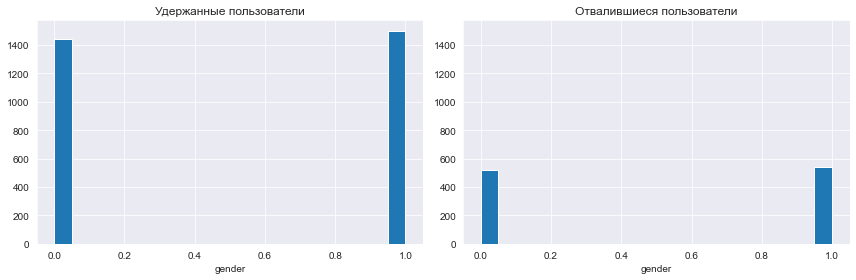

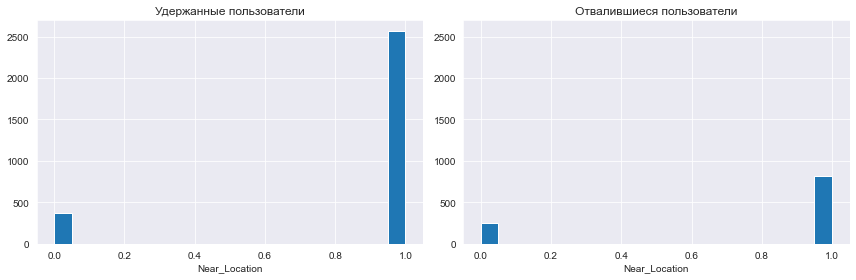

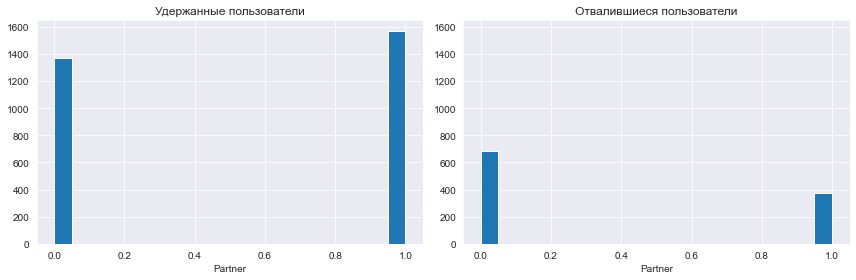

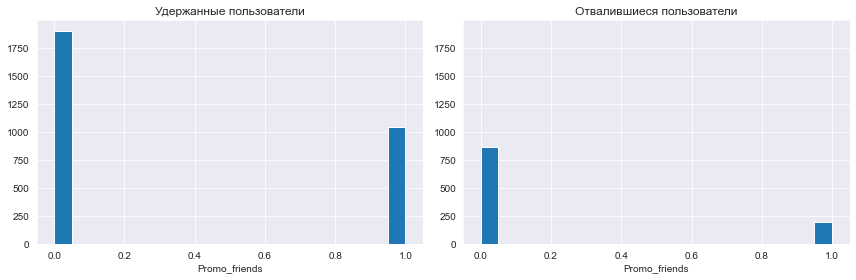

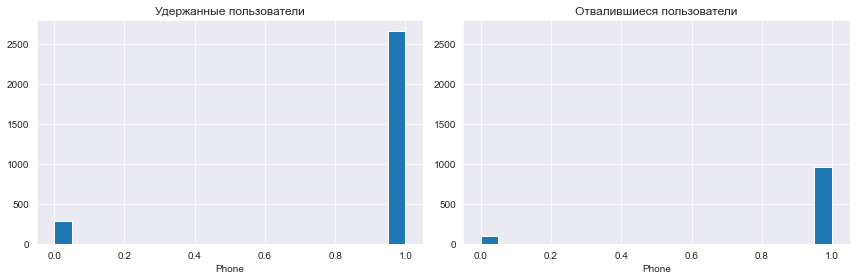

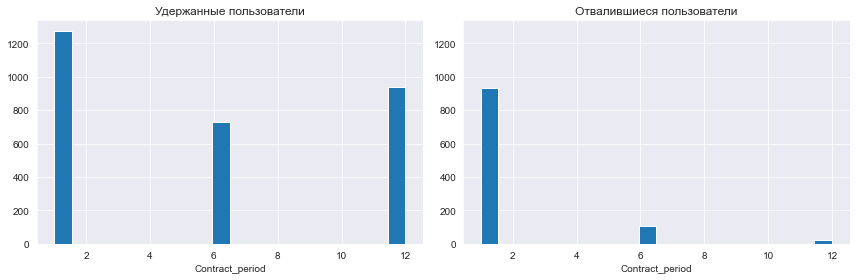

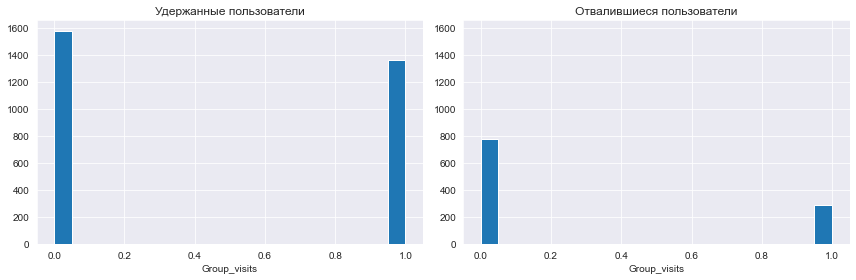

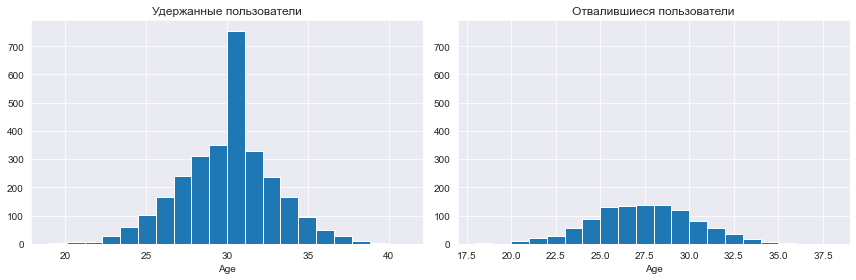

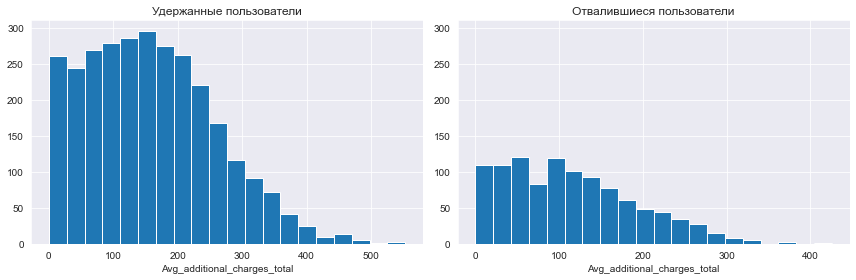

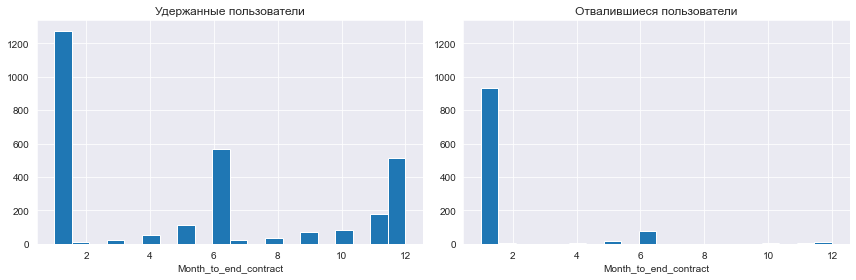

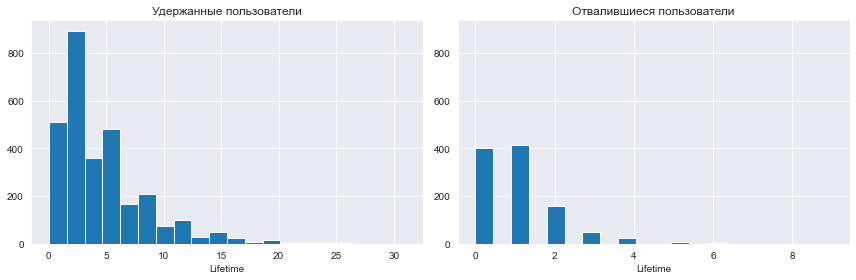

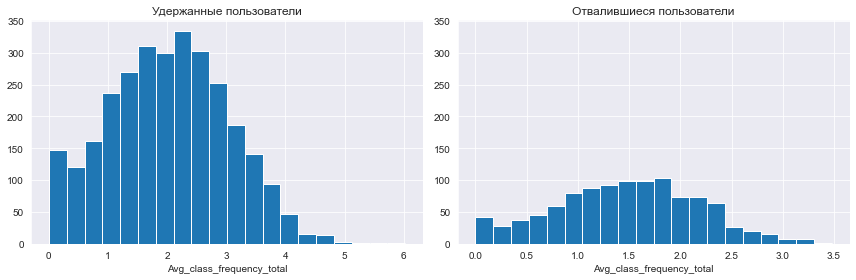

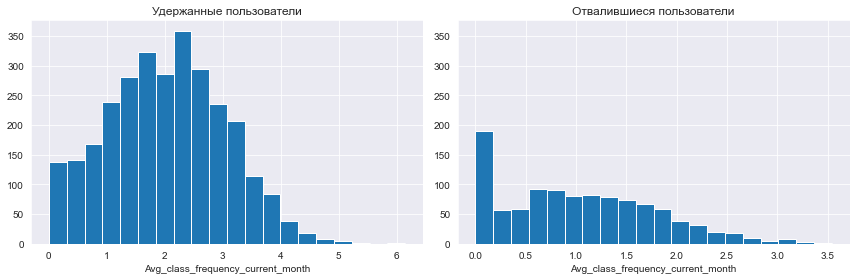

In [11]:
# Напишет цикл, который построит отдельные гистрограммы для каждого признака, кроме самого Churn

for c in list(data.drop(columns = ['Churn']).columns):
    
    plt.figure(figsize=(12, 4))
    
    ax1 = plt.subplot(1, 2, 1)
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    
    # Plot for churn = 0
    ax1.hist(churn_0_data[c], bins=20) 
    ax1.set_title('Удержанные пользователи')
    ax1.set_xlabel(c)
    ax1.set_ylabel('')
    
    # Plot for churn = 1
    ax2.hist(churn_1_data[c], bins=20)  # Replace 'column_name' with the column you want to plot
    ax2.set_title('Отвалившиеся пользователи')
    ax2.set_xlabel(c)
    
    plt.tight_layout()  # To ensure the plots do not overlap
    plt.show()

Основные выводы:

* По полу обе группы распределены почти поровну.
* Среди удержанных клиентов подавляющее большинство живет или работает около фитнес-центра — 2500 против 400. Среди отвалившихся  клиентов группа людей, живущих или работающих около фитнес-центра, также превалирует, но в меньшей степени — 700 против 250. Можно предположить, что близость фитнес-центра к месту работы или проживания является важным фактором удержаения клиента.
* Среди отвалившихся пользователей совсем небольшая часть пользователей пришла в зал по рекомендации друга — в группе удержанных клиентов количество и доля таких пользователей существенно выше. Можно предоложить, что рекомендация друга также является важным фактором удержания клиента.
* Наиболее часто встречаемая длительность абонемента среди пользователей с оттоком — 1 месяц. 
* Отвалившиется пользователей редко посещают групповые занятия. Численность тех, кто хотя бы раз посетил групповое занятия, составляет менее 300 человек.
* Возрастное распределение пользователей в обеих группах примерно одинаковое. Среди удержанных пользователей много клиентов в возрасте 30 лет.
* Удержанные пользователи тратят существенно больше денег на дополнительные услуги в фитнес-центре.
* Среди отвалившихся пользователей заметен пик в районе нуля в средней частоте посещений в неделю за предыдущий месяц, что логично — отвалившиется пользователи часто ни разу не посещали фитнес-центр за последний месяц. Среди удержанных пользователей пик находится между 2 и 3 посещениями в неделю.

Построим матрицу корреляций всех признаков в виде хитмэпа.

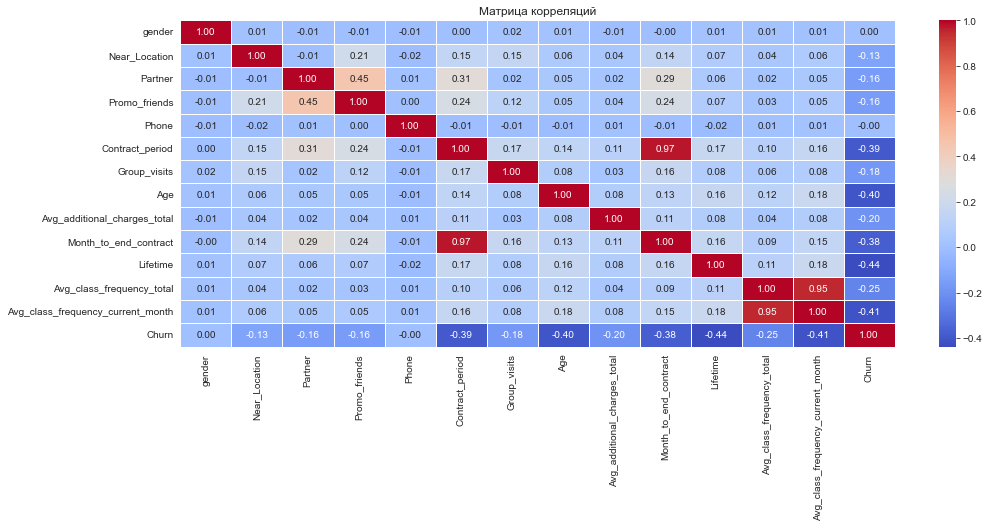

In [12]:
# Зададим размер графика
plt.figure(figsize=(16, 6))

# Построение хитмэпа
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Матрица корреляций')
plt.show()

В целом признаки не сильно коррелируют друг с другом — самая сильная корреляция между признаками  `Month_to_end_contract` и `Contract_period`, а также у `Avg_class_frequency_current_month` и `Avg_class_frequency_total`.

### Построение модели прогнозирования оттока клиентов

Построим модели машинного обучения, которые будут прогнозировать отток клиентов. Создадим модели двух типов — модель логистической регрессии и случайный лес. Для начала разделим датасет на матрицу признаков и вектор целевой переменной. В качестве целевой переменной возьмем факт оттока клиента: Churn = 0 и Churn = 1.

In [13]:
# Разделим данные на матрицу признаков Х и вектор целевых переменных Y
X = data.drop('Churn', axis = 1)
Y = data['Churn']

Теперь разделим датасет на две выборки: обучающую и валидационную

In [14]:
# Разделим модель на обучающую и валидационную выборку
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

Приведем данные в стандартный вид — создадим объект-стандартизатор и применим к выборкам.

In [15]:
# Создание стандартизатора
scaler = StandardScaler()

# Обучение стандартизатора
scaler.fit(X_train)

# Стандартизация матриц с признаками в обучающей и валидационной выборках 
X_train_st = scaler.transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель логистической регрессии и оценим ее качество с помощью метрик `accuracy`, `precision` и `recall`.

In [16]:
# Задаем алгоритм модели
lr_model = LogisticRegression(random_state=0)

# Обучение модели
lr_model.fit(X_train_st, Y_train)

# Прогнозирование данных
lr_predictions = lr_model.predict(X_test_st)

# Расчет метрик accuracy, precision и recall
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, lr_predictions)))
print('Precision: {:.2f}'.format(precision_score(Y_test, lr_predictions)))
print('Recall: {:.2f}'.format(recall_score(Y_test, lr_predictions)))

Accuracy: 0.92
Precision: 0.85
Recall: 0.83


Теперь обучим модель типа "случайный лес"

In [17]:
# Задаем алгоритм модели
rf_model = RandomForestClassifier(n_estimators = 100, random_state=0)

# Обучение модели
rf_model.fit(X_train, Y_train)

# Прогнозирование данных
rf_predictions = rf_model.predict(X_test)

print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(Y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(Y_test, rf_predictions)))

Accuracy: 0.92
Precision: 0.84
Recall: 0.82


**Вывод**: обе модели одинаково хорошо справляются с прогнозированием оттока клинетов.

### Кластеризация клиентов

Теперь проведем кластеризацию клиентов. Для начала отбросим целевой показатель оттока и приведем данные в стандартный вид.

In [18]:
# Стандартизация данных
x_sc = scaler.fit_transform(data.drop(columns = ['Churn']))

Теперь построим дендрограмму для выделения кластеров методом агломеративной иерархической кластеризации


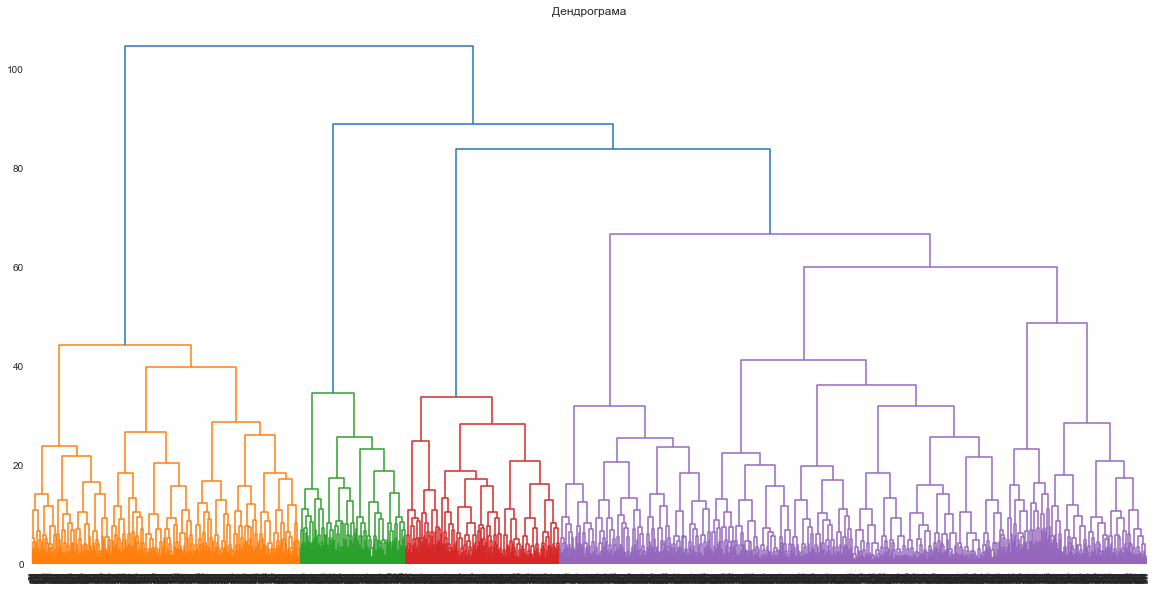

In [19]:
# Создадим матрицу расстояний
linked = linkage(x_sc, method = 'ward') 

# Построим дендрограмму


plt.figure(figsize=(20, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограма')
plt.show()



На основании дендрограммы можно выделить четыре кластера 

Теперь воспользуемся методом кластеризации K-Means — зададим 5 кластеров и посмотрим на средние значения всех признаков внутри каждого кластера.

In [20]:
# Задаём число кластеров, равное 5
km = KMeans(n_clusters=5, random_state=0) 

# Применяем алгоритм к данным и формируем вектор кластеров
labels = km.fit_predict(x_sc) 

# Сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels

# Выводим статистику по средним значениям наших признаков по кластерам
display (data.groupby('cluster_km').mean())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
cluster_km,,,,,,,,,,,,,,
0,0.502970,0.959406,0.783168,0.574257,1.000000,10.889109,0.542574,29.982178,160.761016,9.954455,4.736634,1.982055,1.974789,0.027723
1,0.522078,0.862338,0.470130,0.306494,0.000000,4.787013,0.425974,29.301299,143.957664,4.475325,3.924675,1.847220,1.716369,0.267532
2,0.495050,0.000000,0.463366,0.079208,1.000000,2.352475,0.215842,28.477228,135.457501,2.198020,2.809901,1.660461,1.477324,0.443564
3,0.485737,1.000000,0.350238,0.240095,1.000000,1.948494,0.341521,28.167987,131.622204,1.856577,2.440571,1.247634,1.012983,0.514263
4,0.559666,0.976134,0.356802,0.230310,0.998807,2.669451,0.473747,30.125298,161.657905,2.459427,4.898568,2.852002,2.850161,0.068019


Можно заметить, что по некоторым признакам выделенные кластеры почти не отличаются — например, у клиентов из всех кластеров почти одинаковое половое распределение и средний возраст. По некоторым признакам одни кластеры отличаются существенно, а другие нет — например, кластеры 2 и 3 сильно отличаются по факту проживания/работы у фитнес центра, а кластеры 0, 1 и 4 по этому же признаку отличаются не так значительно. 

В целом по таблице средних значений можно выделить основные характеристики клиентов, которые склонны к оттоку. Наиболее склонные к оттоку  кластеры под номерами 2 и 3, так среди них самая большая доля клиентов со значением Churn = 1. Их объединяет: низкая посещаемость групповых занятий, небольшая длительность абонемента.

Посмотрим на распределение кластеров по категориальными признакам — построим график типа `countplot`

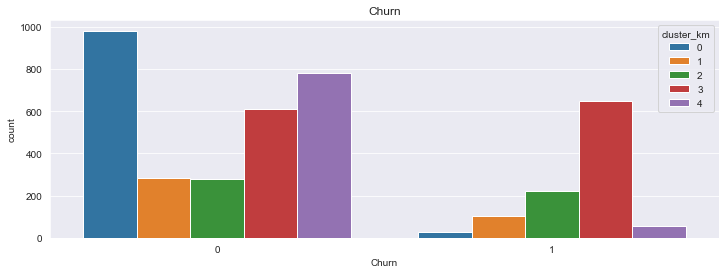

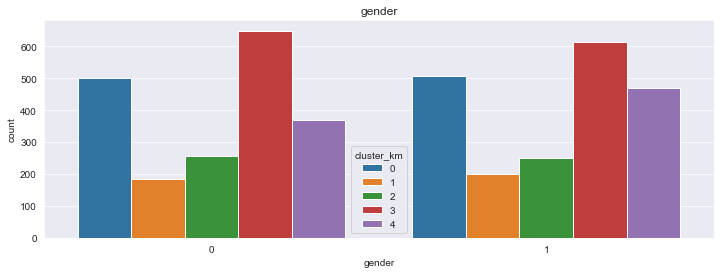

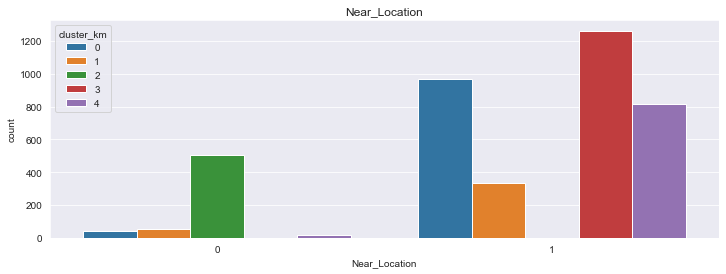

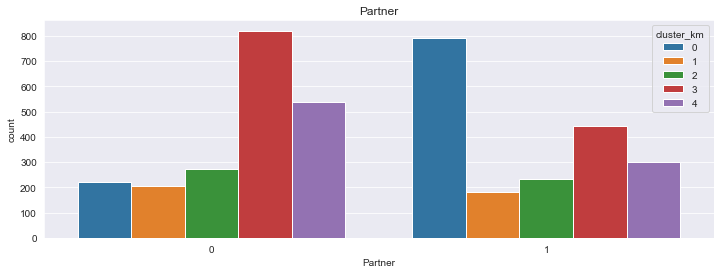

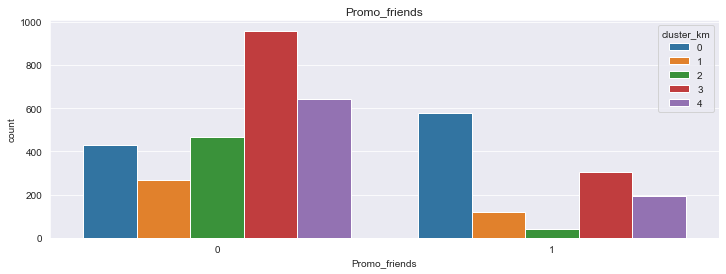

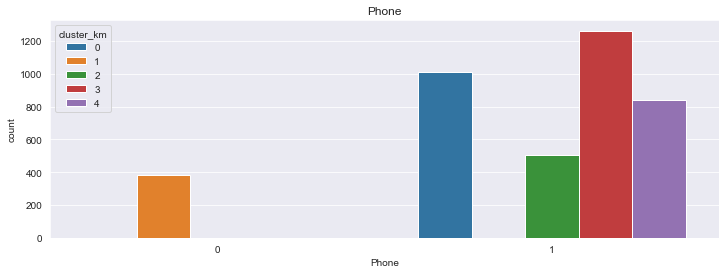

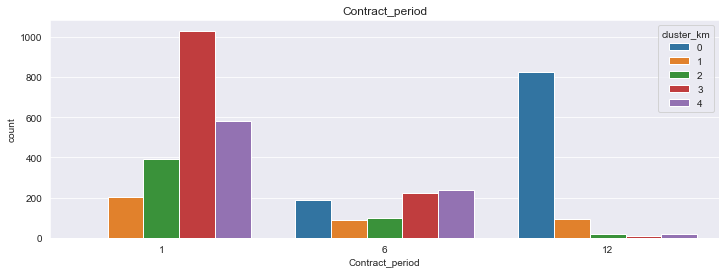

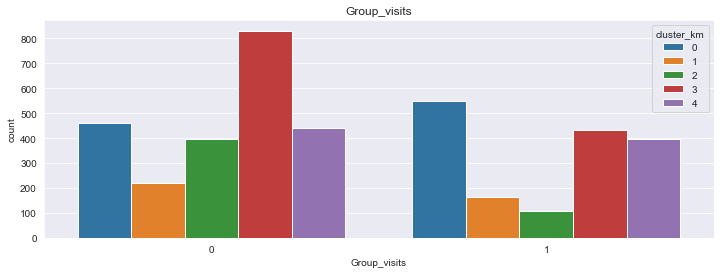

In [21]:
# Создадим список с категориальными столбцами
categorical_columns = ['Churn',
                       'gender',
                       'Near_Location',
                       'Partner',
                       'Promo_friends',
                       'Phone',
                       'Contract_period',
                       'Group_visits',
                       ]

# Для каждого столбца сделаем график в разбивке на кластеры
for column in categorical_columns:
    plt.figure(figsize=(12,4))
    sns.countplot(x=data[column], hue='cluster_km', data=data)
    plt.title(column)
    plt.show()

**Выводы**:



* Нулевой кластер наиболее лоялен к услугам фитнес-центра — это самый часто встречающийся кластер в группе удержанных пользователей и наименее встречающийся кластер в группе отвалившихся пользователей. Среди отвалившихся пользователей больше всего представителей третьего кластера — около 600 клиентов.
* Среди клиентов, которые живут или работают около фитнес-центра больше всего представителей третьего кластера — того самого, который чаще всего отваливается. В то же время, в этой группе достаточно много клиентов из "лояльных" кластеров под номерами 0 и 4.
* По графику с распределение кластеров по значению `Promo Friends` и `Partner` видно, что представители третьего кластара редко приходят в фитнес-центр по рекомендации друга или от компании-партнера. По первому кластеру картина обратная. Из этого можно сделать вывод, что рекомендация друга и работа в компании-партнере являются важными факторами удержания.
* Представители третьего кластера почти не посещают групповые занятия.
* По длительности абонемента прослеживается логика — наименее лояльные кластеры берут абонемент на более короткий срок.
* Распределение пользователей по кластерам среди мужчин и женщин одинаковое

Теперь построим график типа `kdeplot` для численных столбцов:

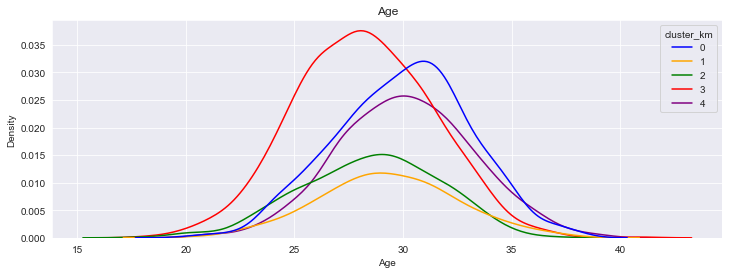

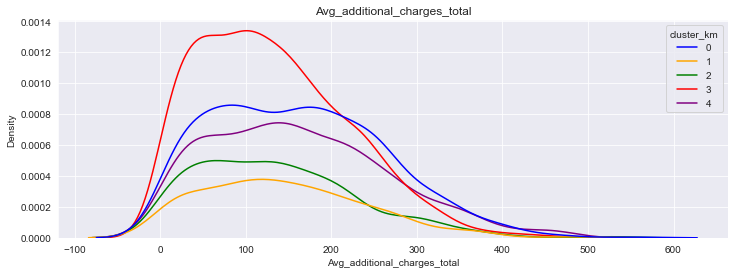

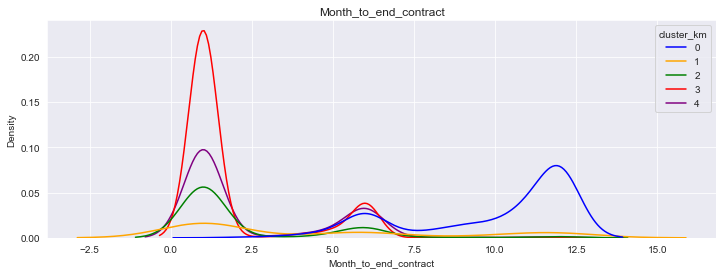

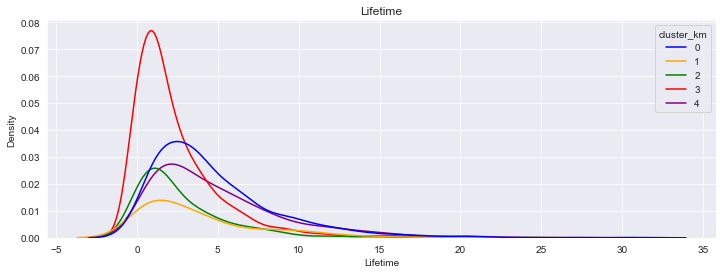

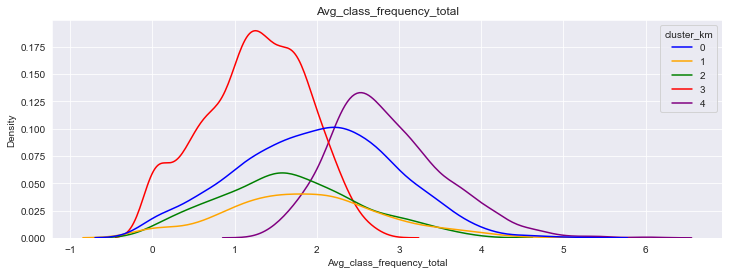

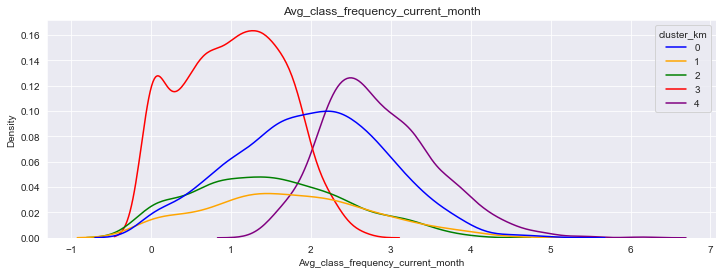

In [22]:
# Создадим список с численными столбцами
numeric_columns = ['Age',
                   'Avg_additional_charges_total',
                   'Month_to_end_contract',
                   'Lifetime',
                   'Avg_class_frequency_total',
                   'Avg_class_frequency_current_month']

custom_palette = ["blue", "orange", "green", 'red', 'purple']

# Для каждого столбца сделаем график в разбивке на кластеры
for column in numeric_columns:
    plt.figure(figsize=(12,4))
    sns.kdeplot(x=data[column], hue='cluster_km', data=data, palette=custom_palette)
    plt.title(column)
    plt.show()

**Выводы:**

* Среди кластеров заметны существеные отличия в частое помещений в неделю — в третьем и втором кластерах чаще всего клиенту посещают зал около одного раза, клиенты остальных кластеров, как правило, ходят в зал чаще — 2 и более раз.
* Среди представителей третьего кластера много пользователей, у которых скоро заканчивается договор — это сваязано с тем, что представители этого кластера берут абонемент на короткий срок.
* Возрастое распределение кластеров примерно одинаковое — от 27 до 32 лет, третий кластер самый молодой.

Рассчитаем долю оттока для каждого кластера.

In [23]:
# Группировка датасета по параметру cluster_km и расчет доли клиентов, для которых Churn = 1
data.groupby('cluster_km')['Churn'].mean()

cluster_km
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: Churn, dtype: float64

Видно, что кластеры под номерами 2 и 3 наименее лояльны к услугам фитнес-центра — в этих кластерах доля оттока самая высокая 44% и 51% соответственно.

### Выводы и рекомендации

В ходе исследования был выполнен анализ сети фитнес-центоров на основании данных об оттоке клинетов с различными признаками

**Описание работ**

* Проверка качества данных: поиск дубликатов, оценка статистических выбросов.
* Исследовательский анализ данных: описание распределения признаков с помощью гистрограмм, построение матрицы корреляций.
* Построение моделей машинного обучения двумя способами, оценка качества прогнозов моделей.
* Выделение и анализ кластеров клиентов

**Основные выводы**

* По полу обе группы распределены почти поровну.
* Возрастное распределение пользователей в обеих группах также примерно одинаковое.
* Среди удержанных клиентов подавляющее большинство живет или работает около фитнес-центра. Близость фитнес-центра к месту работы или проживания является важным фактором удержания клиента.
* Наиболее часто встречаемая длительность абонемента среди пользователей с оттоком — 1 месяц. 
* Отвалившиется пользователей редко посещают групповые занятия. Численность тех, кто хотя бы раз посетил групповое занятия, составляет менее 300 человек.
* Удержанные пользователи тратят существенно больше денег на дополнительные услуги в фитнес-центре.
* Среди отвалившихся пользователей заметен пик в районе нуля в средней частоте посещений в неделю за предыдущий месяц, что логично — отвалившиется пользователи часто ни разу не посещали фитнес-центр за последний месяц. Среди удержанных пользователей пик находится между 2 и 3 посещениями в неделю.
* Кластеры под номерами 2 и 3 наименее лояльны к услугам фитнес-центра — в этих кластерах самая высокая доля оттока. Их объединяет: низкая посещаемость групповых занятий, небольшая длительность абонемента.


**Рекомендации**

* Сфокусировать маркетинговые усилия на людях, которые работают или живут около фитнес-центра. Попытка привлечь клиентов, которые живут или работают далеко от фитнес центра, вероятно, не принесет успех и не окупит маркетинговые затраты. Можно проработать маркетинговую стратегию таргетирования на тех, кто продолжительное время находится в радиусе 5-10 километров от фитнес-центра.
* Среди отвалившихся пользователей много тех, кто ни разу не посетил групповые занятия — возможно, они не нашли то, что их интересует. Можно провести опрос среди этой аудитории, что понять, наличие каких групповых занятий может поспособствовать их удержанию.
* Достаточно много пользователей с оттоком купили абонемент на короткий срок. Возможно, имеет смысл сделать покупку абонемента на длительный срок более выгодной — это потенциально может позволнить удержать клиента. 